In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, classification_report, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
import numpy as np

#dataset
data = pd.read_csv("cleaned_data_15_4_2024.csv")

#Define features and targets 
feature_columns = ['age', 'Violence and Abuse', 'Accidents and Medical', 'Theft and Fraud',
                   'Loss and Death', 'gender_Female', 'gender_Male', 'gender_Other']
targets = ['Personal Support', 'Professional and Specialized Support','Community and Workplace Support', 'Legal and Official Support', 'No Help Sought']

#Split data based on the survey year
train_data = data[data['year_of_survey'] <= 2021]
validation_data = data[data['year_of_survey'] == 2022]
test_data = data[data['year_of_survey'] == 2023]

X_train, y_train = train_data[feature_columns], train_data[targets]
X_val, y_val = validation_data[feature_columns], validation_data[targets]
X_test, y_test = test_data[feature_columns], test_data[targets]

#Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

#Hyperparameters to tune
param_grid = {
    'randomforestclassifier__n_estimators': [100, 200, 300],
    'randomforestclassifier__max_depth': [None, 10, 20, 30],
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__min_samples_leaf': [1, 2, 4]
}

#Scoring for GridSearchCV
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(recall_score, average='macro')}

#Create an empty list
classifiers = []

#Apply SMOTEENN and GridSearchCV for each label individually
for i, target in enumerate(targets):
    smote_enn = SMOTEENN(smote=SMOTE(random_state=42), enn=EditedNearestNeighbours(sampling_strategy='all'), random_state=42)
    X_resampled, y_resampled = smote_enn.fit_resample(X_train_scaled, y_train[target])
    
    #Define the random forest model pipeline
    pipeline = Pipeline([
        ('randomforestclassifier', RandomForestClassifier(random_state=42))
    ])
    
    #Grid search to find the best hyperparameters
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=scoring, refit='AUC')
    grid_search.fit(X_resampled, y_resampled)
    
    #Best model
    best_model = grid_search.best_estimator_
    
    #append the best model to the list 
    classifiers.append(best_model)

y_val_pred = np.column_stack([model.predict(X_val_scaled) for model in classifiers])
y_test_pred = np.column_stack([model.predict(X_test_scaled) for model in classifiers])
y_train_pred = np.column_stack([model.predict(X_train_scaled) for model in classifiers])


precision_train = precision_score(y_train, y_train_pred, average='macro')
recall_train = recall_score(y_train, y_train_pred, average='macro')
f1_train = f1_score(y_train, y_train_pred, average='macro')
roc_auc_train = np.mean([roc_auc_score(y_train.iloc[:, i], y_train_pred[:, i]) for i in range(y_train.shape[1])])

#training set
print(f'Training Precision: {precision_train}')
print(f'Training Recall: {recall_train}')
print(f'Training F1-score: {f1_train}')
print(f'Training ROC-AUC score: {roc_auc_train}')
print("\nTraining Classification Report:\n", classification_report(y_train, y_train_pred, target_names=targets))

precision_val = precision_score(y_val, y_val_pred, average='macro')
recall_val = recall_score(y_val, y_val_pred, average='macro')
f1_val = f1_score(y_val, y_val_pred, average='macro')
roc_auc_val = np.mean([roc_auc_score(y_val.iloc[:, i], y_val_pred[:, i]) for i in range(y_val.shape[1])])

precision_test = precision_score(y_test, y_test_pred, average='macro')
recall_test = recall_score(y_test, y_test_pred, average='macro')
f1_test = f1_score(y_test, y_test_pred, average='macro')
roc_auc_test = np.mean([roc_auc_score(y_test.iloc[:, i], y_test_pred[:, i]) for i in range(y_test.shape[1])])

#validation set
print(f'Validation Precision: {precision_val}')
print(f'Validation Recall: {recall_val}')
print(f'Validation F1-score: {f1_val}')
print(f'Validation ROC-AUC score: {roc_auc_val}')
print("\nValidation Classification Report:\n", classification_report(y_val, y_val_pred, target_names=targets))

#test set
print(f'Test Precision: {precision_test}')
print(f'Test Recall: {recall_test}')
print(f'Test F1-score: {f1_test}')
print(f'Test ROC-AUC score: {roc_auc_test}')
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred, target_names=targets))


Training Precision: 0.468243399872981
Training Recall: 0.6341239475809947
Training F1-score: 0.5129748316758133
Training ROC-AUC score: 0.6795639458919311

Training Classification Report:
                                       precision    recall  f1-score   support

                    Personal Support       0.92      0.75      0.83      7215
Professional and Specialized Support       0.44      0.71      0.54      1825
     Community and Workplace Support       0.46      0.48      0.47      2427
          Legal and Official Support       0.37      0.76      0.49      1323
                      No Help Sought       0.15      0.47      0.23       471

                           micro avg       0.58      0.69      0.63     13261
                           macro avg       0.47      0.63      0.51     13261
                        weighted avg       0.69      0.69      0.67     13261
                         samples avg       0.61      0.70      0.61     13261

Validation Precision: 0.4250

C:\Users\Christina Meinti\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Christina Meinti\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Christina Meinti\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [4]:
import pandas as pd

#Define the evaluation metrics for each data split
metrics_data = {
    'Data Split': ['Train', 'Validation', 'Test'],
    'Precision': [precision_train, precision_val, precision_test],
    'Recall': [recall_train, recall_val, recall_test],
    'F1 Score': [f1_train, f1_val, f1_test],
    'ROC-AUC': [roc_auc_train, roc_auc_val, roc_auc_test]
}

results_df = pd.DataFrame(metrics_data)

#Display the DataFrame
print(results_df)
results_df.to_csv("Random_Forest_evaluation_metrics.csv", index=False)

   Data Split  Precision    Recall  F1 Score   ROC-AUC
0       Train   0.468243  0.634124  0.512975  0.679564
1  Validation   0.425035  0.553001  0.458911  0.616685
2        Test   0.427650  0.564777  0.461162  0.625809


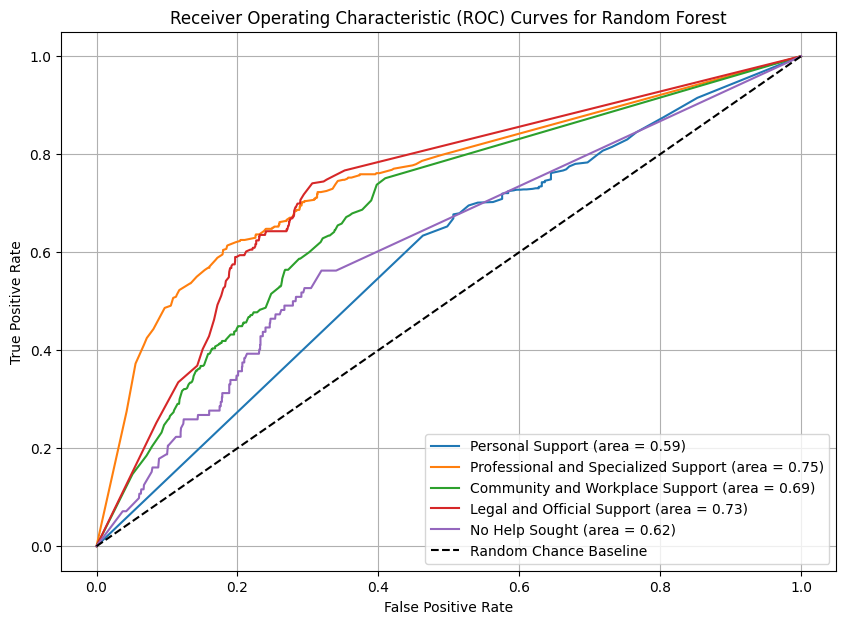

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

#plot ROC-AUC curves
def plot_multiclass_roc_auc(y_true, y_scores, targets, figsize=(10, 7)):
    
    plt.figure(figsize=figsize)

    
    for i, target in enumerate(targets):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f'{target} (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance Baseline')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves for Random Forest')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

y_scores = np.column_stack([model.predict_proba(X_test_scaled)[:, 1] for model in classifiers])
y_true = y_test.to_numpy()
#Plot ROC-AUC curves
plot_multiclass_roc_auc(y_true, y_scores, targets)